In [31]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

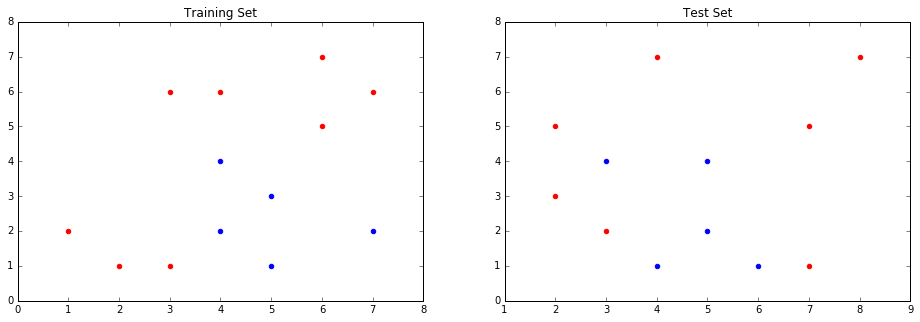

In [32]:
def plot_set(h,X1,X2, ax=plt, title='Set'):
    ax.scatter(x=X1[:h], y=X2[:h], color='b' )
    ax.scatter(x=X1[h:], y=X2[h:], color='r' )
    ax.set_title( title )

# These are the Activation Functions.
def sigmoid(x):
	return 2*1/(1+np.exp(-x)) - 1

def step(x):
    return np.where( x > 0, 1, -1 )    

# Number of neurons in each layer
NEURONS = [ 2, 3, 1 ]

# Training and Test set
TRAIN_X1 = [ 4, 4, 5, 5, 7,      1,  2,  3,  6,  3,  6,  4,  7 ]
TRAIN_X2 = [ 2, 4, 3, 1, 2,      2,  1,  1,  5,  6,  7,  6,  6 ]
TRAIN_Z  = [ 1, 1, 1, 1, 1,     -1, -1, -1, -1, -1, -1, -1, -1 ]
TRAIN_N  = len(TRAIN_X1)
TRAIN_X0 = np.ones(TRAIN_N)

TEST_X1 = [ 4, 5, 3, 5, 6, 7,    3,  8,  4,  7,  2,  2 ]
TEST_X2 = [ 1, 2, 4, 4, 1, 1,    2,  7,  7,  5,  3,  5 ]
TEST_Z  = [ 1, 1, 1, 1, 1, 1,   -1, -1, -1, -1, -1, -1 ]
TEST_N  = len(TEST_X1)
TEST_X0 = np.ones(TEST_N)

TRAIN_X = np.array( [TRAIN_X0, TRAIN_X1, TRAIN_X2] ).T
TEST_X  = np.array( [TEST_X0, TEST_X1, TEST_X2] ).T

fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(16,5) )

plot_set(5, TRAIN_X1, TRAIN_X2, ax1, 'Training Set')
plot_set(5, TEST_X1 , TEST_X2 , ax2, 'Test Set'     )

In [29]:
n = NEURONS[0]
k = NEURONS[1]
m = NEURONS[2]

del_1   = np.empty( k ) # Delta Level 1 layer
del_2   = np.empty( m ) # Delta Level 2 layer

del_w_1 = np.empty( [ n+1, k ] ) # Weight Update L1
del_w_2 = np.empty( [ k+1, m ] ) # Weight Update L2

# Used by TrainAndTest function.
def TestPerformance(W1,W2):
    total_error = 0
    for s in range( 0, TEST_N ):
        O_   = TEST_X[s]
        net1 = np.dot( O_, W1 )
        O1   = sigmoid(net1)
        O1_  = [ 1, *O1 ]
        O2   = np.dot( O1_, W2 )
        total_error += np.abs( ( step(O2) - TRAIN_Z[s] ) ) * 0.5
    return total_error

def TrainAndTest(W1, W2, eta=0.1):
    
    error_TS = []
    norm_1   = []
    norm_2   = []

    for epoch in range( 25000 ):

        del_w_1_avg = np.zeros( [ n+1, k ] )
        del_w_2_avg = np.zeros( [ k+1, m ] )

        total_error = 0

        for s in range( TRAIN_N ):

            # First step: feed-forward computation
            O_   = TRAIN_X[s]
            O    = TRAIN_X[s][1:]

            net1 = np.dot( O_, W1 )

            O1   = sigmoid(net1)
            O1_  = [ 1, *O1 ]

            O2   = np.dot( O1_, W2 )

            # Second step: backpropagation to the output layer
            for j in range( 0, m ) :  # For us, j=0 only
                del_2[j] = ( step(O2[j]) - TRAIN_Z[s] ) # * O2[j] * (1 - O2[j])

            # Third step: backpropagation to the hidden layer
            for j in range( 0, k ) :  # This should be vectorialized
                del_1[j] = O1[j] * (1 - O1[j]) * W2[j,:] * del_2

            # Fourth step: weight updates
            for i in range(k+1):
                for j in range(m):
                    del_w_2[i,j] = - eta * O1_[i] * del_2[j]

            for i in range(n+1):
                for j in range(k):
                    del_w_1[i,j] = - eta * O_[i] * del_1[j]

            del_w_1_avg += del_w_1 / TRAIN_N
            del_w_2_avg += del_w_2 / TRAIN_N

            total_error += np.abs( ( step(O2) - TRAIN_Z[s] ) ) * 0.5

        W1 += del_w_1_avg
        W2 += del_w_2_avg

        error_TS.append( total_error[0] )
        norm_1.append( np.abs( W1 ).sum() )
        norm_2.append( np.abs( W2 ).sum() )

        if total_error == 0 : break
    
    testPerf = TestPerformance(W1,W2)
    
    return epoch, testPerf, error_TS   

def present_results(epochs, testPerfs, error_TSs, eta=0.1):
    
    print('Eta: {0}'.format(eta) )
    print( 'Average   epochs: {0}'.format( np.mean( epochs ) ) )
    # print( 'Std. dev. epochs: {0}'.format( np.std ( epochs ) ) )
    #print()
    print( 'Average   test performance: {0}'.format( np.mean( testPerfs ) ) )
    # print( 'Std. dev. test performance: {0}'.format( np.std ( testPerfs ) ) )
    print()
    print()

    # Padding
    lenghts = [ len(x) for x in error_TSs ]
    L = np.max( lenghts )
    error_TSs_pad  = [ np.pad( x, (0,L-len(x)), 'constant', constant_values=0 ) for x in error_TSs]
    error_TSs_mean = np.mean( error_TSs_pad, axis=0 )

    # Plotting
    plt.plot(range(0,len(error_TSs_mean)), error_TSs_mean, label='Error with eta = {0}'.format(eta)   )
    _ = plt.legend()

In [33]:
%%time
epochs    = []
testPerfs = []
error_TSs = []
for r in range(10):
    print(r)
    # Random initial weights ( Including Bias )
    W1 = np.random.uniform( -.1, .1, size=( NEURONS[0]+1, NEURONS[1] ) )
    W2 = np.random.uniform( -.1, .1, size=( NEURONS[1]+1, NEURONS[2] ) )
    epoch, testPerf, error_TS = TrainAndTest(W1, W2)
    epochs   .append( epoch    )
    testPerfs.append( testPerf )
    error_TSs.append( error_TS )

0


/Users/GiorgioZacharo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


1
2
3
4
5
6
7
8
9
CPU times: user 1min 53s, sys: 632 ms, total: 1min 54s
Wall time: 1min 54s


Eta: 0.1
Average   epochs: 18756.9
Average   test performance: 4.4




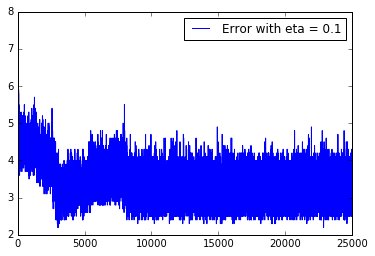

In [34]:
present_results(epochs, testPerfs, error_TSs)

In [35]:
%%time

results = {}

for eta in [10, 1, 1/10, 1/100, 1/1000]:
    
    print('Eta: {0}'.format(eta) )

    epochs    = []
    testPerfs = []
    error_TSs = []

    for r in range(10):
        # Random initial weights ( Including Bias )
        W1 = np.random.uniform( -.1, .1, size=( NEURONS[0]+1, NEURONS[1] ) )
        W2 = np.random.uniform( -.1, .1, size=( NEURONS[1]+1, NEURONS[2] ) )
        epoch, testPerf, error_TS = TrainAndTest(W1, W2, eta)
        epochs   .append( epoch    )
        testPerfs.append( testPerf )
        error_TSs.append( error_TS )
    
    results[eta] = epochs, testPerfs, error_TSs

Eta: 10


/Users/GiorgioZacharo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


Eta: 1
Eta: 0.1
Eta: 0.01
Eta: 0.001
CPU times: user 10min 48s, sys: 3.27 s, total: 10min 52s
Wall time: 10min 50s


Eta: 10
Average   epochs: 24999.0
Average   test performance: 6.6


Eta: 1
Average   epochs: 24999.0
Average   test performance: 5.6


Eta: 0.1
Average   epochs: 19014.0
Average   test performance: 4.2


Eta: 0.01
Average   epochs: 15550.0
Average   test performance: 4.1


Eta: 0.001
Average   epochs: 23058.2
Average   test performance: 3.9




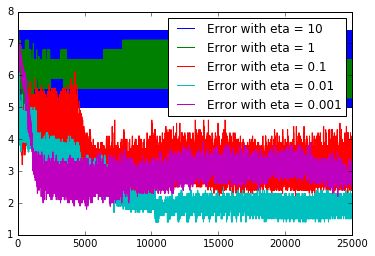

In [36]:
for eta in [10, 1, 1/10, 1/100, 1/1000]:
    present_results( *results[eta], eta )

In [13]:
for s in range( 0, TRAIN_N ):
    # Feed-forward computation
    O_   = TRAIN_X[s]
    net1 = np.dot( O_, W1 )
    O1   = sigmoid(net1)
    O1_  = [ 1, *O1 ]
    O2   = np.dot( O1_, W2 )
    print( step(O2) )

[1]
[1]
[1]
[1]
[1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
